# Assignment: Voter classification using exit poll data

*Fraida Fund*

**TODO**: Edit this cell to fill in your NYU Net ID and your name:

-   **Net ID**:
-   **Name**:

In this notebook, we will explore the problem of voter classification.

Given demographic data about a voter and their opinions on certain key issues, can we predict their vote in the 2020 U.S. presidential election? We will attempt this using a K nearest neighbor classifier.

In the first few sections of this notebook, I will show you how to prepare the data and and use a K nearest neighbors classifier for this task, including:

-   getting the data and loading it into the workspace.
-   preparing the data: dealing with missing data, encoding categorical data in numeric format, and splitting into training and test.

In the last few sections of the notebook, you will have to improve the basic model for better performance, using a custom distance metric and using feature weighting. In these sections, you will have specific criteria to satisfy for each task.

**However, you should also make sure your overall solution is good!** An excellent solution to this problem will achieve greater than 80% test accuracy. A great solution will achieve 75% or higher.

(A K nearest neighbor model is not necessarily the best model for this data - but the experience of *improving* the K nearest neighbor model will be a useful learning experience for us. In particular, it is a nice demonstration of how plugging some data into an `sklearn` classifier is not the beginning and end of model training!)

#### 📝 Specific requirements

-   For full credit, you should achieve 75% or higher test accuracy overall in this notebook (i.e. when running your solution notebook from beginning to end).

## Import libraries

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import ShuffleSplit, KFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

np.set_printoptions(suppress=True)

## Load data

The data for this notebook comes from the [U.S. National Election Day Exit Polls](https://ropercenter.cornell.edu/exit-polls/us-national-election-day-exit-polls).

Here’s a brief description of how election day exit polls work.

Exit polls are conducted by Edison Research on behalf of a consortium of media organizations.

First, the member organizations decide what races to cover, what sample size they want, what questions should be asks, and other details. Then, sample precincts are selected, and local interviewers are hired and trained. Then, at those precincts, the local interviewer approaches a subset of voters as they exit the polls (for example, every third voter, or every fifth voter, depending on the required sample size).

When a voter is approached, they are asked if they are willing to fill out a questionnaire. Typically about 40-50% agree. (For those that decline, the interviewer visually estimates their age, race, and gender, and notes this information, so that the response rate by demographic is known and responses can be weighted accordingly in order to be more representative of the population.)

Voters that agree to participate are then given an form with 15-20 questions. They fill in the form (anonymously), fold it, and put it in a small ballot box.

Several times during the day, the interviewers will stop, take the questionnaires, compile the results, and call them in to the Edison Research phone center. The results are reported immediately to the media organizations that are consortium members.

In addition to the poll of in-person voters, absentee and early voters (who are not at the polls on Election Day) are surveyed by telephone.

### Download the data and documentation

The exit poll data is not freely available on the web, but is available to those with institutional membership. You will be able to use your NYU email address to create an account with which you can download the exit poll data.

To get the data:

1.  Visit [the Roper Center website via NYU Libraries link](https://persistent.library.nyu.edu/arch/NYU02495). Click on the user icon in the top right of the page, and choose “Log in”.
2.  For “Your Affiliation”, choose “New York University”.
3.  Then, click on the small red text “Register” below the password input field. The email and password fields will be replaced by a new email field with two parts.
4.  Enter your NYU email address in the email field, and then click the red “Register” button.
5.  You will get an email at your NYU email address with the subject “Roper iPoll Account Registration”. Open the email and click “Confirm Account” to create a password and finish your account registration.
6.  Once you have completed your account registration, log in to Roper iPoll by clicking the user icon in the top right of the page, choosing “Log in”, and entering your NYU email address and password.
7.  Then, open the Study Record for the [2020 National Election Day Exit Poll](https://ropercenter.cornell.edu/ipoll/study/31119913).
8.  Click on the “Downloads” tab, and then click on the CSV data file in the “Datasets” section of this tab. Press “Accept” to accept the terms and conditions. Find the file `31119913_National2020.csv` in your browser’s default download location.
9.  After you download the CSV file, also download the PDF `31119913_National2020.pdf` from the “Study Documentation” section.

### Upload into Colab filesystem

To get the data into Colab, run the following cell. Upload the CSV file you just downloaded (`31119913_National2020.csv`) to your Colab workspace. Wait until the uploaded has **completely** finished - it may take a while, depending on the quality of your network connection.

In [95]:
try:
  from google.colab import files

  uploaded = files.upload()

  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

except:
  pass # not running in Colab

### Load data with pandas

Now, use the `read_csv` function in `pandas` to read in the file.

Also use `head` to view the first few rows of data and make sure that everything is read in correctly.

In [96]:
df = pd.read_csv('31119913_National2020.csv')
df.head()

,id,weight,pres,hou,abort2,abortion,acasupre,age,age3,age10,...,vote2016,voteexpe,voteex_1,votemeth,work,worksex,wprotbrn,wprotb_1,wrkwomen,wrkwom_1
0,152520,0.206209,Did not vote,,Omit,Omit,,45-64,30-59,45-49,...,,,,Election day,,,No,,,
1,142428,0.209581,Did not vote,,,,,18-29,18-29,18-24,...,,,,Election day,,,,,,
2,117340,0.016127,Joe Biden,,,,Keep it as is,65+,60+,65-74,...,,,,By mail,,,,,,
3,115688,0.019268,Joe Biden,,Legal,Legal in all cases,,65+,60+,65-74,...,,,,By mail,,,No,,,
4,126835,0.021964,Joe Biden,,,,,30-44,30-59,40-44,...,Hillary Clinton,,,Election day,Yes,Working men,,,All others,Working men


## Prepare data

Survey data can be tricky to work with, because surveys often “branch”; the questions that are asked depends on a respondent’s answers to other questions.

In this case, different respondents fill out different versions of the survey. Review pages 17, 18, 19, 20 of the “Study Documentation” PDF file you downloaded earlier, which shows the different questionnaire versions used for the 2020 exit polls.

Note that in a red box next to each question, you can see the name of the variable (column name) that the respondent’s answer will be stored in.

<figure>
<img src="https://raw.githubusercontent.com/ffund/ml-notebooks/master/notebooks/images/exit-poll-survey-versions-2020.png" alt="Exit poll versions" />
<figcaption aria-hidden="true">Exit poll versions</figcaption>
</figure>

This cell will tell us how many respondents answered each version of the survey:

In [97]:
df['version'].value_counts()

,count
version,
Version 2,3906
Version 1,3894
Version 3,3797
Version 4,3754


Because each respondent answers different questions, for each row in the data, only some of the columns - the columns corresponding to questions included in that version of the survey - have data. Our classifier will need to handle that.

You may also notice that the data is *categorical*, not *numeric* - for each question, users choose their response from a finite set of possible answers. We will need to convert this type of data into something that our classifier can work with.

### Label missing data

Since each respondent only saw a subset of questions, we expect to see missing values in each column.

However, if we look at the **count** of values in each column, we see that there are no missing values - every column has the full count!

In [98]:
df.describe(include='all')

,id,weight,pres,hou,abort2,abortion,acasupre,age,age3,age10,...,vote2016,voteexpe,voteex_1,votemeth,work,worksex,wprotbrn,wprotb_1,wrkwomen,wrkwom_1
count,15351.000000,15351.000000,15351,15351,15351,15351,15351,15351,15351,15351,...,15351,15351,15351,15351,15351,15351,15351,15351,15351,15351
unique,NaN,NaN,5,5,4,6,4,5,4,11,...,6,6,4,3,3,5,3,4,3,5
top,NaN,NaN,Joe Biden,The Democratic candidate,,,,45-64,30-59,50-59,...,,,,Election day,,,,,,
freq,NaN,NaN,7949,7673,11678,11678,11561,5163,8064,2594,...,11541,11644,11644,10636,11484,11488,11751,13092,11462,11488
mean,132125.457169,1.031724,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,13136.354533,2.957104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,113675.000000,0.001839,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,119452.500000,0.250881,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,131273.000000,0.462229,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,144141.000000,0.845175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


This is because missing values are recorded as a single space, and not with a NaN.

Let’s change that:

In [99]:
df.replace(" ", float("NaN"), inplace=True)

Now we can see an accurate count of the number of responses in each column:

In [100]:
df.describe(include='all')

,id,weight,pres,hou,abort2,abortion,acasupre,age,age3,age10,...,vote2016,voteexpe,voteex_1,votemeth,work,worksex,wprotbrn,wprotb_1,wrkwomen,wrkwom_1
count,15351.000000,15351.000000,15151,14874,3673,3673,3790,15252,15252,15252,...,3810,3707,3707,15351,3867,3863,3600,2259,3889,3863
unique,NaN,NaN,4,4,3,5,3,4,3,10,...,5,5,3,3,2,4,2,3,2,4
top,NaN,NaN,Joe Biden,The Democratic candidate,Legal,Legal in most cases,Keep it as is,45-64,30-59,50-59,...,Hillary Clinton,Very easy,Very easy or somewhat easy,Election day,Yes,Working men,No,All others,All others,Working men
freq,NaN,NaN,7949,7673,2033,1050,2063,5163,8064,2594,...,1520,2662,3402,10636,2472,1288,3017,1259,2707,1288
mean,132125.457169,1.031724,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,13136.354533,2.957104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,113675.000000,0.001839,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,119452.500000,0.250881,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,131273.000000,0.462229,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,144141.000000,0.845175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Notice that *every* row has some missing data! If we drop the rows with missing values, we’re left with an empty data frame (0 rows):

In [101]:
df.dropna()

,id,weight,pres,hou,abort2,abortion,acasupre,age,age3,age10,...,vote2016,voteexpe,voteex_1,votemeth,work,worksex,wprotbrn,wprotb_1,wrkwomen,wrkwom_1


Instead, we’ll have to make sure that the classifier we use is able to work with partial data. One nice benefit of K nearest neighbors is that it can work well with data that has missing values, as long as we use a distance metric that behaves reasonably under these conditions.

### Encode target variable as a binary variable

Our goal is to classify voters based on their vote in the 2020 presidential election, i.e. the value of the `pres` column. We will restrict our attention to the candidates from the two major parties, so we will throw out the rows representing voters who chose other candidates:

In [102]:
df['pres'].value_counts()

,count
pres,
Joe Biden,7949
Donald Trump,6735
Other,419
Did not vote,48


In [103]:
df = df.loc[df['pres'].isin(['Joe Biden', 'Donald Trump'])]
df.reset_index(inplace=True, drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14684 entries, 0 to 14683
Columns: 118 entries, id to wrkwom_1
dtypes: float64(1), int64(2), object(115)
memory usage: 13.2+ MB


In [104]:
df['pres'].value_counts()

,count
pres,
Joe Biden,7949
Donald Trump,6735


Now, we will transform the string value into a binary variable, and save the result in `y`. We will build a binary classifier that predicts `1` if it thinks a sample is Trump voter, and `0` if it thinks a sample is a Biden voter.

In [105]:
y = df['pres'].map({'Donald Trump': 1, 'Joe Biden': 0})
y.value_counts()

,count
pres,
0,7949
1,6735


### Encode ordinal features

Next, we need to encode our features. All of the features are represented as strings, but we will have to transform them into something over which we can compute a meaningful distance measure.

Columns that have a **logical order** should be encoded using ordinal encoding, so that the distance metric will be meaningful.

For example, consider the `age` column, in which users select an option from the following:

In [106]:
df['age'].unique()

array(['65+', '30-44', '45-64', '18-29', nan], dtype=object)

What if we would transform the `age` column using four binary columns: `age_18-29`, `age_30-44`, `age_45-64`, `age_65+`, with a 0 or a 1 in each column to indicate the respondent’s age?

If we did this, we would lose meaningful information about the distance between ages; a respondent whose age is 18-29 would have the same distance to one whose age is 45-65 as to one whose age is 65+. Logically, we expect that a respondent whose age is 18-29 is most similar to the other 18-29 respondents, less similar to the 30-44 respondents, even less similar to the 45-65 respondents, and least similar to the 65+ respondents.

To realize this, we will use **ordinal encoding**, which will represent `age` in a single column with *ordered* integer values.

First, we define a dictionary that maps each possible value to an integer.

In [107]:
mapping_dict_age = {'18-29': 1,
                 '30-44': 2,
                 '45-64': 3,
                 '65+': 4}

Then we can create a new data frame, `df_enc_ord`, by calling `map` on the original `df['age']` and passing this mapping dictionary. We will also specify that the index should be the same as the original data frame:

In [108]:
df_enc_ord = pd.DataFrame( {'age': df['age'].map( mapping_dict_age) },
    index = df.index
)

We can extend this approach to encode more than one ordinal feature. For example, let us consider the column `educ18`, which includes the respondent’s answer to the question:

> Which best describes your education? You have:
>
> 1.  Never attended college
> 2.  Attended college but received no degree
> 3.  Associate’s degree (AA or AS)
> 4.  Bachelor’s degree (BA or BS)
> 5.  An advanced degree after a bachelor’s degree (such as JD, MA, MBA, MD, PhD)

In [109]:
df['educ18'].value_counts()

,count
educ18,
Bachelor's degree (BA or BS),4074
Attended college but received no degree,3497
Never attended college,2541
"An advanced degree after a bachelor's degree (such as JD, MA, MBA, MD, PhD)",2391
Associate's degree (AA or AS),2181


We can map both `age` and `educ18` to ordinal-encoded columns in a new data frame:

In [110]:
mapping_dict_age = {'18-29': 1,
                 '30-44': 2,
                 '45-64': 3,
                 '65+': 4}
mapping_dict_educ18 =  {"Never attended college": 1,
                   "Attended college but received no degree": 2,
                   "Associate's degree (AA or AS)": 3,
                   "Bachelor's degree (BA or BS)": 4,
                   "An advanced degree after a bachelor's degree (such as JD, MA, MBA, MD, PhD)": 5}
df_enc_ord = pd.DataFrame( {
    'age': df['age'].map( mapping_dict_age) ,
    'educ18': df['educ18'].map( mapping_dict_educ18)
    },
    index = df.index
)

Note that the order matters - the “Never attended college” answer should have the smallest value, followed by “Attended college but received no degree”, etc.

Also note that missing values are still treated as missing (not mapped to some value) - this is going to be important, since we are going to design a distance metric that treats missing values sensibly:

In [111]:
df_enc_ord.isna().sum()

,0
age,89
educ18,0


There’s one more important step before we can use our ordinal-encoded values with KNN.

Note that the values in the encoded columns range from 1 to the number of categories. For K nearest neighbors, the “importance” of each feature in determining the class label would be proportional to its scale (because the value of the feature is used directly in the distance metric). If we leave it as is, any feature with a larger range of possible values will be considered more “important!”, i.e. would count more in the distance metric.

So, we will re-scale our encoded features to the unit interval. We can do this with the `MinMaxScaler` in `sklearn`.

(Note: in general, you’d “fit” scalers etc. on only the training data, not the test data! In this case, however, the min and max in the training data is just due to our encoding, and will definitely be the same as the test data, so it doesn’t really matter.)

In [112]:
scaler = MinMaxScaler()

# first scale in numpy format, then convert back to pandas df
df_scaled = scaler.fit_transform(df_enc_ord)
df_enc_ord = pd.DataFrame(df_scaled, columns=df_enc_ord.columns)

In [113]:
df_enc_ord.describe()

,age,educ18
count,14595.000000,14684.000000
mean,0.513532,0.504716
std,0.337134,0.340851
min,0.000000,0.000000
25%,0.333333,0.250000
50%,0.666667,0.500000
75%,0.666667,0.750000
max,1.000000,1.000000


Later, you’ll design a model with more ordinal features. For this initial demo, though, we’ll stick to just those two - age and education - and continue to the next step.

### Encode categorical features

In the previous section, we encoded features that have a logical ordering.

Other categorical features, such as `qraceai` (race), have no logical ordering. It would be wrong to assign an ordered mapping to these features. These should be encoded using **one-hot encoding**, which will create a new column for each unique value, and then put a 1 or 0 in each column to indicate the respondent’s answer.

(Note: for features that have two possible values - binary features - either categorical encoding or one-hot encoding would be valid!)

In [114]:
df['race'].value_counts()

KeyError: 'race'

We can one-hot encode this column using the `get_dummies` function in `pandas`. (If we were working with data in a `numpy` array, we might choose to use the [`OneHotEncoder`](https://scikit-learn.org/dev/modules/generated/sklearn.preprocessing.OneHotEncoder.html) in `sklearn` instead, but since we have a `pandas` data frame we will stick to the `pandas` function.)

In [115]:
df_enc_oh = pd.get_dummies(df['qraceai'], prefix='race', dtype=np.int32)

In [116]:
df_enc_oh.describe()

,race_American Indian,race_Asian,race_Black,race_Hispanic/Latino,race_Other,race_White
count,14684.000000,14684.000000,14684.000000,14684.000000,14684.000000,14684.000000
mean,0.011986,0.029420,0.133002,0.123944,0.029215,0.667461
std,0.108825,0.168986,0.339588,0.329529,0.168416,0.471139
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Note that we added a `race` prefix to each column name - this prevents overlap between columns, e.g. if we also encoded another feature where “Other” was a possible answer. And, it helps us relate the new columns back to the original survey question that they answer.

For this survey data, we want to preserve information about missing values - if a sample did not have a value for the `qraceai` feature, we want it to have a NaN in all `race` columns. We can assign NaN to those rows as follows:

In [117]:
df_enc_oh.loc[df['qraceai'].isnull(), df_enc_oh.columns.str.startswith("race_")] = float("NaN")

Now, for respondents where this feature is not available, we have a NaN in all `RACE` columns:

In [118]:
df_enc_oh.isnull().sum()

,0
race_American Indian,73
race_Asian,73
race_Black,73
race_Hispanic/Latino,73
race_Other,73
race_White,73


### Stack columns

Now, we’ll prepare our feature data, by column-wise concatenating the ordinal-encoded feature columns and the one-hot-encoded feature columns:

In [119]:
X = pd.concat([df_enc_oh, df_enc_ord], axis=1)

### Get training and test indices

We’ll be working with many different subsets of this dataset, including different columns.

So instead of splitting up the data into training, validation, and test sets, we’ll get an array of training indices and an array of test indices. Then, we can use these arrays throughout this notebook.

In [120]:
idx_tr, idx_ts = train_test_split(np.arange(0, df.shape[0]), test_size = 0.3, random_state = 3)

I specified the state of the random number generator for repeatability, so that every time we run this notebook we’ll have the same split. This makes it easier to discuss specific examples.

Now, we can use the `pandas` function `.iloc` to get the training and test parts of the data set for any column.

For example, if we want the training subset of `y`:

In [121]:
y.iloc[idx_tr]

,pres
11967,1
8888,1
5763,0
12986,1
3275,0
...,...
9160,1
9859,1
11513,1
1688,0


or the test subset of `y`:

In [122]:
y.iloc[idx_ts]

,pres
13213,1
454,0
144,0
1502,0
5751,0
...,...
14312,1
3020,0
10064,1
3882,0


Here are the summary statistics for the training data:

In [123]:
X.iloc[idx_tr].describe()

,race_American Indian,race_Asian,race_Black,race_Hispanic/Latino,race_Other,race_White,age,educ18
count,10222.000000,10222.000000,10222.000000,10222.000000,10222.000000,10222.000000,10213.000000,10278.000000
mean,0.012033,0.029642,0.128448,0.126785,0.028468,0.674623,0.514932,0.506470
std,0.109038,0.169606,0.334605,0.332749,0.166314,0.468538,0.337175,0.341239
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.250000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.666667,0.500000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.666667,0.750000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Train a k nearest neighbors classifier

Now that we have a target variable, a few features, and training and test indices, let’s see what happens if we try to train a K nearest neighbors classifier.

### Baseline: “prediction by mode”

As a baseline against which to judge the performance of our classifier, let’s find out the accuracy (on the test set) of a classifier that gives the majority class label (0) to all samples in our test set:

In [124]:
y_pred_baseline = np.repeat(0, len(y.iloc[idx_ts]))
accuracy_score(y.iloc[idx_ts], y_pred_baseline)

0.5449387199273718

A classifier trained on the data should do *at least* as well as the one that predicts the majority class label. Hopefully, we’ll be able to do much better!

### `KNeighborsClassifier` does not support data with NaNs

We’ve previously seen the `sklearn` implementation of a `KNeighborsClassifier`. However, that won’t work for this problem. If we try to train a `KNeighborsClassifier` on our data using the default settings, it will fail with the error message

    ValueError: Input X contains NaN.

See for yourself:

In [125]:
clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(X.iloc[idx_tr], y.iloc[idx_tr])


ValueError: Input X contains NaN.
KNeighborsClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

This is because we have many missing values in our data. And, as we explained previously, dropping rows with missing values is not a good option for this example.

Although we cannot use the `sklearn` implementation of a `KNeighborsClassifier`, we can write our own. We need a few things:

-   a function that implements a distance metric
-   a function that accepts a distance matrix and returns the indices of the K smallest values for each row
-   a function that returns the majority vote of the training samples represented by those indices

and we have to be prepared to address complications at each stage!

Note: as an alternative to writing our own implementation of KNN, we could work around the issue of missing values by pre-computing a distance matrix and passing it to the `sklearn` implementation of `KNeighborsClassifer`, but that option has other problems we haven’t discussed yet. We’ll jump straight to writing our own implementation, since that will give us more flexibility to solve those problems.

### Distance metric

Let’s start with the distance metric. Suppose we use an L1 distance computed over the features that are non-NaN for both samples:

In [126]:
def custom_distance(a, b):
  d = np.zeros(shape=(a.shape[0], b.shape[0]))
  for i, a_row in enumerate(a):
    dif = np.abs(np.subtract(a_row,b))    # element-wise absolute difference
    # dif will have NaN for each element where either a or b is NaN
    l1 = np.nansum(dif, axis=1)  # sum of differences, treating NaN as 0
    d[i] = l1
  return d

The function above expects an array for the first argument with shape `(num_rows_a, d)` and an array for the second argument with shape `(num_rows_b, d)`. It returns an array with shape `(num_rows_a, num_rows_b)`. An entry in row $i$, column $j$ is the distance between row $i$ of array `a` and row `j` of array `b`.

To see how to this function is used, let's consider an example with a small number of test samples and training samples.

Suppose we had this set of data `a` (sampling some specific examples from the real data) for which we want to make predictions:

In [127]:
a_idx = np.array([2881,  7911])
a = X.iloc[a_idx]
a

,race_American Indian,race_Asian,race_Black,race_Hispanic/Latino,race_Other,race_White,age,educ18
2881,0.0,0.0,0.0,0.0,0.0,1.0,0.333333,1.0
7911,0.0,0.0,0.0,1.0,0.0,0.0,0.333333,0.0


and this set of training data `b`, which we have stored as our model “training” step:

In [128]:
b_idx = np.array([9665, 924, 6892, 10632, 11989, 5613, 7035, 7062, 928, 14113])
b = X.iloc[b_idx]
b

,race_American Indian,race_Asian,race_Black,race_Hispanic/Latino,race_Other,race_White,age,educ18
9665,0.0,0.0,0.0,1.0,0.0,0.0,0.666667,0.00
924,0.0,0.0,0.0,1.0,0.0,0.0,0.333333,1.00
6892,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.25
10632,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.25
11989,0.0,0.0,0.0,0.0,0.0,1.0,0.333333,0.00
5613,0.0,0.0,0.0,0.0,0.0,1.0,0.666667,1.00
7035,0.0,0.0,0.0,0.0,0.0,1.0,0.666667,0.00
7062,0.0,0.0,0.0,0.0,0.0,1.0,0.666667,0.75
928,0.0,0.0,0.0,0.0,0.0,1.0,0.666667,0.25
14113,0.0,0.0,0.0,0.0,0.0,1.0,NaN,0.25


We need to compute the distance from each sample in the new data `a`, to each sample in the training data `b`.

We will set up a *distance matrix* in which to store the results. In the distance matrix, an entry in row $i$, column $j$ represents the distance between row $i$ of the new data and row $j$ of the training set.

So the distance matrix should have as many rows as there are test samples, and as many columns as there are training samples.

In [129]:
distances_custom = custom_distance(X.iloc[a_idx].to_numpy(), X.iloc[b_idx].to_numpy())

Let’s look at those distances now:

In [130]:
np.set_printoptions(precision=2) # show at most 2 decimal places
print(distances_custom)

[[3.33 2.   3.08 3.08 1.   0.33 1.33 0.58 1.08 0.75]
 [0.33 1.   2.58 0.58 2.   3.33 2.33 3.08 2.58 2.25]]


### Find most common class of k nearest neighbors

Now that we have a distance matrix, for each test sample, we can:

-   get an array of indices from the *distance matrix*, sorted in order of increasing distance
-   get the list of the K nearest neighbors as the first K elements from that list,
-   from those entries - which are indices with respect to the distance matrix - get the corresponding indices in `X` and `y`,
-   and then predict the class of the test sample as the most common value of `y` among the nearest neighbors.

In [131]:
k = 3
# array of indices sorted in order of increasing distance
distances_sorted = np.argsort(distances_custom, axis=1)
# first k elements in that list = indices of k nearest neighbors
nn_lists = distances_sorted[:, :k]
# map indices in distance matrix back to indices in `X` and `y`
nn_lists_idx = b_idx[nn_lists]
# for each test sample, get the mode of `y` values for the nearest neighbors
y_pred =  [y.iloc[nn].mode()[0] for nn in nn_lists_idx]

### Example: one test sample

For example, this was the first “new” sample:

In [132]:
X.iloc[[2881]]

,race_American Indian,race_Asian,race_Black,race_Hispanic/Latino,race_Other,race_White,age,educ18
2881,0.0,0.0,0.0,0.0,0.0,1.0,0.333333,1.0


Here is its distance to each of the training samples in our “mini” training set:

In [133]:
distances_custom[0]

array([3.33, 2.  , 3.08, 3.08, 1.  , 0.33, 1.33, 0.58, 1.08, 0.75])

and here’s the sorted list of indices from that distance matrix - i.e. the index of the training sample with the smallest distance, the index of the training sample with the second-smallest distance, and so on.

In [134]:
distances_sorted[0]

array([5, 7, 9, 4, 8, 6, 1, 2, 3, 0])

The indices (in the “mini” training sample) of the 3 nearest neighbors to this test sample are:

In [135]:
nn_lists[0]

array([5, 7, 9])

which corresponds to the following sample indices in the complete data `X`:

In [136]:
nn_lists_idx[0]

array([ 5613,  7062, 14113])

So, its closest neighbors in the “mini” training set are:

In [137]:
X.iloc[nn_lists_idx[0]]

,race_American Indian,race_Asian,race_Black,race_Hispanic/Latino,race_Other,race_White,age,educ18
5613,0.0,0.0,0.0,0.0,0.0,1.0,0.666667,1.00
7062,0.0,0.0,0.0,0.0,0.0,1.0,0.666667,0.75
14113,0.0,0.0,0.0,0.0,0.0,1.0,NaN,0.25


and their corresponding values in `y` are:

In [138]:
y.iloc[nn_lists_idx[0]]

,pres
5613,0
7062,0
14113,1


and so the predicted label for the first test sample would be:

In [139]:
y.iloc[nn_lists_idx[0]].mode().values

array([0])

### Example: entire test set

Now that we understand how our custom distance function works, let’s compute the distance between every *test* sample and every *training* sample.

We’ll store the results in `distances_custom`.

In [140]:
distances_custom = custom_distance(X.iloc[idx_ts].to_numpy(), X.iloc[idx_tr].to_numpy())

Then, we can compute the K nearest neighbors using those distances:

In [141]:
k = 3

# get nn indices in distance matrix
distances_sorted = np.argsort(distances_custom, axis=1)
nn_lists = distances_sorted[:, :k]

# map indices in distance matrix back to indices in `X` and `y`
nn_lists_idx = idx_tr[nn_lists]

# predict using mode of nns
y_pred =  [y.iloc[nn].mode()[0] for nn in nn_lists_idx]

In [142]:
accuracy_score(y.iloc[idx_ts], y_pred)

0.6286881525192919

That is… not great.

### Problems with our simple classifier

Using similar “toy” examples, we will illustrate some basic problems with our classifier, and explain some of the reasons for its poor performance:

-   the distance metric does not tell us how *similar* two samples are, when there are samples with missing values,
-   and the way that ties are handled - when there are multiple samples in the training set with the same distance - is not ideal.

We’ll discuss both of these, but we’ll only fix the second one in this section. Part of *your* assignment will be to address the issue with the custom distance metric in your solution.

First, let’s talk about ties! Consider the following “new” sample -

In [143]:
a_idx = np.array([4553])
X.iloc[a_idx]

,race_American Indian,race_Asian,race_Black,race_Hispanic/Latino,race_Other,race_White,age,educ18
4553,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


and training samples -

In [144]:
b_idx = np.array([13648, 13896, 13916, 13967, 7727, 8073, 8101, 8241])
X.iloc[b_idx]

,race_American Indian,race_Asian,race_Black,race_Hispanic/Latino,race_Other,race_White,age,educ18
13648,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
13896,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
13916,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
13967,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7727,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8073,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8101,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8241,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Notice that these samples are identical with respect to the feature data! but they are not identical with respect to the target variable -

In [145]:
y.iloc[b_idx]

,pres
13648,1
13896,1
13916,1
13967,1
7727,0
8073,0
8101,0
8241,0


However, when we train a nearest neighbors classifier on this data -

In [146]:
k = 3

# compute distances
distances_custom  = custom_distance(X.iloc[a_idx].to_numpy(), X.iloc[b_idx].to_numpy())

# get nn indices in distance matrix
distances_sorted = np.argsort(distances_custom, axis=1)
nn_lists = distances_sorted[:, :k]

# map indices in distance matrix back to indices in `X` and `y`
nn_lists_idx = b_idx[nn_lists]

# predict using mode of nns
y_pred =  [y.iloc[nn].mode()[0] for nn in nn_lists_idx]

we see that although there are eight training samples with *equal* distance to the test sample, the nearest neighbor classifier just takes the first K of them as nearest neighbors.

In [147]:
X.iloc[nn_lists_idx[0]]

,race_American Indian,race_Asian,race_Black,race_Hispanic/Latino,race_Other,race_White,age,educ18
13648,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
13896,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
13916,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In other words: ties are broken in favor of the samples that happen to be recorded earlier in the data.

On a larger scale, that means that some samples will have too much influence - they will appear over and over again as nearest neighbors, *just because they are earlier in the data* - while some samples will not appear as nearest neighbors at all simply because of this tiebreaker behavior.

A better tiebreaker behavior would be to randomly sample from neighbors with equal distance. Fortunately, this is an easy fix:

-   We had been using `argsort` to get the K smallest distances to each test point. However, if there are more than K training samples that are at the minimum distance for a particular test point (i.e. a tie of more than K values, all having the minimum distance), `argsort` will return the first K of those in order of their index in the distance matrix (their order in `idx_tr`).
-   Now, we will use an alternative, `lexsort`, that sorts first by the second argument, then by the first argument; and we will pass a random array as the first argument:

In [148]:
# make a random matrix
r_matrix = np.random.random(size=(distances_custom.shape))

# sort using lexsort - first sort by distances_custom, then by random matrix in case of tie
distances_sorted= np.lexsort((r_matrix, distances_custom))
nn_lists = distances_sorted[:, :k]

# map indices in distance matrix back to indices in `X` and `y`
nn_lists_idx = b_idx[nn_lists]

# predict using mode of nns
y_pred =  [y.iloc[nn].mode()[0] for nn in nn_lists_idx]

In [149]:
X.iloc[nn_lists_idx[0]]

,race_American Indian,race_Asian,race_Black,race_Hispanic/Latino,race_Other,race_White,age,educ18
13916,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8101,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8241,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [150]:
y_pred

[0]

Now, if you run the few cells above several times, you will see that the “tie” is broken in favor of *different* equally distance samples each time, and the prediction changes accordingly.

Let’s get the accuracy of *this* classifier, with the better tiebreaker behavior, on our entire test set -

In [151]:
distances_custom = custom_distance(X.iloc[idx_ts].to_numpy(), X.iloc[idx_tr].to_numpy())

In [152]:
# make a random matrix
r_matrix = np.random.random(size=(distances_custom.shape))

# sort using lexsort - first sort by distances_custom, then by random matrix in case of tie
distances_sorted= np.lexsort((r_matrix, distances_custom))
nn_lists = distances_sorted[:, :k]

# map indices in distance matrix back to indices in `X` and `y`
nn_lists_idx = idx_tr[nn_lists]

# predict using mode of nns
y_pred =  [y.iloc[nn].mode()[0] for nn in nn_lists_idx]

In [153]:
accuracy_score(y.iloc[idx_ts], y_pred)

0.606218792555606

This classifier is less “fragile” - less sensitive to the draw of training data.

Depending on the random draw of training and test data, it may or may not have better performance for a particular split - but that’s largely because our classifier is just not very good. Once we have created a better overall classifier, then having a more reasonable tiebreaker behavior will make a big difference!

For the rest of this project, we will use the random tiebreaker behavior whenever we train a KNN classifier.

Now, let’s talk about the other major problem:

-   the distance metric does not tell us how *similar* two samples are, when there are samples with missing values,

Consider the following “new” sample:

    [1, 1, 1]

and these training samples:

    [ [1,   1,   1],
      [nan, nan, nan],
      [0,   0,   0]]

Using our `custom_distance` function, we would compute:

-   the distance between the “new” sample and the first training sample is 0,
-   the distance between the “new” sample and the third training sample is 3, the max possible value

all of which makes sense. However, the distance between the “new” sample and the second training sample - which has all missing values - is also 0!

In fact, this sample will be a “nearest neighbor” of *every* test sample! But, it’s not necessarily *really* similar to those other test samples. We just *don’t have any information* by which to judge how similar it is to other samples. These values are *unknown*, not *similar*.

The case with an all-NaN training sample is a bit extreme, but it illustrates how our simple distance metric is problematic in other situations as well. In general, when there are no missing values, for a pair of samples each feature is either *similar* or *different*. Thus a metric like L1 distance, which explicitly measures the extent to which features are *different*, also implicitly captures the extent to which features are *similar*.

When samples can have missing values, though, for a pair of samples each feature is either *similar*, *different*, or *unknown* (one or both samples is missing that value). In this case, a distance metric that only measures the extent of *difference* (like L1 or L2 distance) does not capture whether the features that are not different are *similar* or *unknown*. (Our custom distance metric, which is an L1 distance, treats values that are *unknown* as if they are *similar* - neither one increases the distance.) Similarly, a distance metric that only measures the extent of *similarity* would not capture whether the features that are not similar are *different* or *unknown*.

Logically, the distance between a known value and an unknown value (or between two unknown values) is undefined - we do not know how different the values are. However, we cannot classify samples with an “undefined” distance, so our `custom_distance` uses [`np.nansum`](https://numpy.org/doc/stable/reference/generated/numpy.nansum.html) which ignores missing values and does not include them when summing the feature-wise distance. Our distance metric effectively only considers difference, not similarity.

A better distance metric will consider the level of disagreement between samples, but will also consider the level of agreement. That will be part of your assignment - to write a new `custom_distance`.

### Use K-fold CV to select the number of neighbors

In the previous example, we set the number of neighbors to 3, rather than letting this value be dictated by the data.

As a next step, to improve the classifier performance, we can use K-fold CV to select the number of neighbors. Note that depending how we do it, this can be *very* computationally expensive, or it can be not much more computationally expensive than just fixing the number of neighbors ourselves.

The most expensive part of the algorithm is computing the distance to the training samples. This is $O(nd)$ for each test sample, where $n$ is the number of training samples and $d$ is the number of features. If we can make sure this computation happens only once, instead of once per fold, this process will be fast.

Here, we pre-compute our distance matrix for *every* training sample:

In [154]:
# pre-compute a distance matrix of training vs. training data
distances_kfold = custom_distance(X.iloc[idx_tr].to_numpy(), X.iloc[idx_tr].to_numpy())

Now, we’ll use K-fold CV.

In each fold, as always, we’ll further divide the training data into validation and training sets.

Then, we’ll select the *rows* of the pre-computed distance matrix corresponding to the *validation* data in this fold, and the *columns* of the pre-computed distance matrix corresponding to the *training* data in this fold.

In [155]:
n_fold = 5
k_list = np.arange(1, 301, 10)
n_k = len(k_list)
acc_list = np.zeros((n_k, n_fold))

kf = KFold(n_splits=5, shuffle=True)

for isplit, idx_k in enumerate(kf.split(idx_tr)):

  print("Iteration %d" % isplit)

  # Outer loop: select training vs. validation data (out of training data!)
  idx_tr_k, idx_val_k = idx_k

  # get target variable values for validation data
  y_val_kfold = y.iloc[idx_tr[idx_val_k]]

  # get distance matrix for validation set vs. training set
  distances_val_kfold   = distances_kfold[idx_val_k[:, None], idx_tr_k]

  # generate a random matrix for tie breaking
  r_matrix = np.random.random(size=(distances_val_kfold.shape))

  # loop over the rows of the distance matrix and the random matrix together with zip
  # for each pair of rows, return sorted indices from distances_val_kfold
  distances_sorted = np.lexsort((r_matrix, distances_val_kfold))

  # Inner loop: select value of K, number of neighbors
  for idx_k, k in enumerate(k_list):

    # now we select the indices of the K smallest, for different values of K
    # the indices in  distances_sorted are with respect to distances_val_kfold
    # from those - get indices in idx_tr_k, then in X
    nn_lists_idx = idx_tr[idx_tr_k[distances_sorted[:,:k]]]

    # get validation accuracy for this value of k
    y_pred =  [y.iloc[nn].mode()[0] for nn in nn_lists_idx]
    acc_list[idx_k, isplit] = accuracy_score(y_val_kfold, y_pred)

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4


Here’s how the validation accuracy changes with number of neighbors:

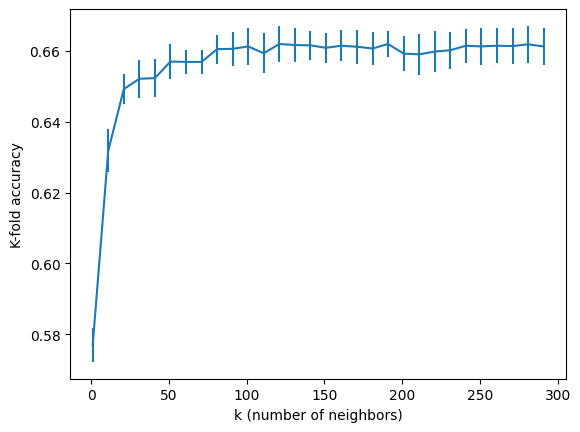

In [156]:
plt.errorbar(x=k_list, y=acc_list.mean(axis=1), yerr=acc_list.std(axis=1)/np.sqrt(n_fold-1));

plt.xlabel("k (number of neighbors)");
plt.ylabel("K-fold accuracy");

Using this, we can find a better choice for k (number of neighbors):

In [157]:
best_k = k_list[np.argmax(acc_list.mean(axis=1))]
print(best_k)

121


Now, let’s re-run our KNN algorithm using the entire training set and this `best_k` number of neighbors, and check its accuracy on the test data?

In [158]:
distances_custom = custom_distance(X.iloc[idx_ts].to_numpy(), X.iloc[idx_tr].to_numpy())

# make a random matrix
r_matrix = np.random.random(size=(distances_custom.shape))

# sort using lexsort - first sort by distances_custom, then by random matrix in case of tie
distances_sorted= np.lexsort((r_matrix, distances_custom))
nn_lists = distances_sorted[:, :best_k]

# map indices in distance matrix back to indices in `X` and `y`
nn_lists_idx = idx_tr[nn_lists]

# predict using mode of nns
y_pred =  [y.iloc[nn].mode()[0] for nn in nn_lists_idx]

In [159]:
accuracy_score(y.iloc[idx_ts], y_pred)

0.6591012256014526

It’s better - but is it the best we can do?

### Summarizing our basic classifier

Our basic classifier, with the improvements we introduced:

-   uses three features (age, race, and education) to predict a respondent’s vote
-   doesn’t mind if there are NaNs in the data (unlike the `sklearn` implementation, which throws an error)
-   uses a random tiebreaker if there are multiple training samples with the same distance to the test sample
-   uses the number of neighbors with the best validation accuracy, according to K-fold CV.

But, there are some outstanding issues:

-   the distance metric only cares about the degree of disagreement (difference) between two samples, and doesn’t balance it against the degree of agreement (similarity).
-   we have only used three features, out of many more available features.

For this assignment, you will create an even better classifier by improving on those two issues.

## Create a better classifier

In the remaining sections of this notebook, you’ll need to fill in code to:

-   implement a custom distance metric
-   encode more features
-   implement feature weighting
-   “train” and evaluate your final classifier, including K-Fold CV to select the best value for number of neighbors.

### Create a better distance metric

Your first task is to improve on the basic distance metric we used above. Your distance metric should satisfy the following criteria:

1.  if two samples are identical, the distance between them should be zero.
2.  as the extent of *difference* between two samples increases, the distance should increase.
3.  as the extent of *similarity* between two samples increases, the distance should decrease.
4.  if in a pair of samples one or both have a NaN value for a given feature, the similarity or difference of this feature is *unknown*. Your distance metric should compute a smaller distance for a pair of samples with many similarities (even if there is some small difference) than for a pair of samples with mostly unknown similarity.

Note that `numpy` includes many functions that are helpful when working with arrays that have NaN values, including mathematical functions like [sum](https://numpy.org/doc/stable/reference/generated/numpy.nansum.html), [product](https://numpy.org/doc/stable/reference/generated/numpy.nanprod.html), [max](https://numpy.org/doc/stable/reference/generated/numpy.nanmax.html) and [min](https://numpy.org/doc/stable/reference/generated/numpy.nanmin.html), and logic functions like [isnan](https://numpy.org/doc/stable/reference/generated/numpy.isnan.html).

To realize these goals, you should modify the `custom_distance` function as follows:

-   for a row in `a` and each row in `b`, count the number of values missing in *either* `a`, `b`, or both.
-   then, compute a penalty that scales with “number of missing values”. Add this penalty to the L1 distance that the original `custom_distance` computes.

#### 📝 Specific requirements

**Function signature**: Your `custom_distance` should accept a 2D array `a` (representing a set of “new” samples) as its first argument, and a 2D array `b` (representing a set of training samples) as its second argument. Then, it returns an array with shape `(n_rows_a, n_rows_b)`, with the distance between each row of `a` and each row of `b`.

**Missing values**: Your `custom_distance` function should *not* impute 0s or any other value in place of `NaN` values in either `a` or `b`.

**Intermediate variables**: Your function should compute the following values, using each row in `a` against the rows in `b`:

-   `l1` = total magnitude of “disagreements”/“known dissimilarity” between `a` and each row in `b` (This is the L1 distance for known values). It is already computed by the original `custom_distance`.
-   `n_nan` = total number of NaN/“unknown” values where either `a` *OR* the corresponding row of `b` (or both!) has a NaN.

and you should use both of these (*not* only `l1`) in your distances.

#### Implement your distance metric

In [216]:
# TODO - implement distance metric

def custom_distance(a, b, debug=False):

  # fill in your solution here!

  # this is just a placeholder - your function shouldn't actually return
  # all zeros ;)
  # distances = np.zeros(a.shape[0], b.shape[0])

  a = np.array(a, dtype=float)
  b = np.array(b, dtype=float)

  distances = np.zeros(shape=(a.shape[0], b.shape[0]))
  for i, a_row in enumerate(a):
    dif = np.abs(np.subtract(a_row,b))    # element-wise absolute difference

    # dif will have NaN for each element where either a or b is NaN
    l1 = np.nansum(dif, axis=1)  # sum of differences, treating NaN as 0

    # n_nan = np.isnan(a_row).sum() + np.isnan(b).sum(axis=1) - np.isnan(dif).sum(axis=1)
    n_nan = np.sum(np.isnan(a_row) | np.isnan(b), axis=1)

    distances[i] = l1 + n_nan

  return distances


#### Test cases for your distance metric

You can use these test samples to check your work. (But, your metric should also satisfy the criteria in general - not only for these specific cases!)

First criteria: if two samples are identical, the distance between them should be zero.

In [163]:
a = np.array([[0, 1, 0,      1, 0, 0.3]] )  # A0 - test sample
b = np.array([[0, 1, 0,      1, 0, 0.3]] )  # B0 - same as A0, should have 0 distance
custom_distance(a, b)

array([[0.]])

Second criteria: as the extent of *difference* between two samples increases, the distance should increase.

These should have *increasing* distance:

In [164]:
a = np.array([[0, 1, 0,      1, 0, 0.3]] )  # A0 - test sample
b = np.array([[0, 1, 0,      1, 0, 0.3],              # B0 - same as A0, should have 0 distance
              [0, 1, 0,      1, 0, 0.5],              # B1 - has one small difference, should have larger distance than B0
              [0, 1, 0,      1, 0, 1  ],              # B2 - has more difference, should have larger distance than B1
              [0, 0, 0,      1, 0, 0  ],              # B3 - has even more difference
              [1, 0, 1,      0, 1, 0  ]])             # B4 - has the most difference
custom_distance(a, b)

array([[0. , 0.2, 0.7, 1.3, 5.3]])

These should have *decreasing* distance:

In [165]:
a = np.array([[0, 1, 0, 1, 0, 1]] )            # A0 - test sample
b = np.array([[1, 0, 1, 0, 1, 0],              # B0 - completely different, should have large distance
              [1, 0, 1, 0, 1, np.nan],         # B1 - less difference than B0, should have less distance
              [1, 0, 1, 0, np.nan, np.nan]])   # B2 - even less difference than B1, should have less distance
custom_distance(a, b)

array([[6., 6., 6.]])

Third criteria: as the extent of *similarity* between two samples increases, the distance should decrease.

These should have *increasing* distance:

In [166]:
a = np.array([[0, 1, 0, 1, 0, 0.3]] )  # A0 - test sample
b = np.array([[0, 1, 0, 1, 0, 0.3],              # B0 - same as A0, should have 0 distance
              [0, 1, 0, 1, 0, np.nan],           # B1 - has less similarity than B0, should have larger distance
              [0, 1, 0, 1, np.nan, np.nan],      # B2 - has even less similarity, should have larger distance
              [0, np.nan, np.nan, np.nan, np.nan, np.nan]])     # B3 - has least similarity, should have larger distance
custom_distance(a, b)

array([[0., 1., 2., 5.]])

Fourth criteria: if in a pair of samples one or both have a NaN value for a given feature, the similarity or difference of this feature is *unknown*. Your distance metric should compute a smaller distance for a pair of samples with many similarities (even if there is some small difference) than for a pair of samples with mostly unknown similarity.

These should have *increasing* distance:

In [167]:
a = np.array([[0, np.nan, 0, 1, np.nan, 0.3]] )  # A0 - test sample
b = np.array([[0, np.nan, 0, 1, 0,      0.5],                # B0 - three similar features, one small difference
              [0, np.nan, np.nan, np.nan, np.nan, np.nan]])  # B1 - much less similarity than B0, should have larger distance

custom_distance(a, b)

array([[2.2, 5. ]])

### Encode more features

Our basic classifier used three features: age, race, and education. But there are many more features in this data that may be predictive of vote:

-   More demographic information: `age10`, `sex`, `latino`, `income20`, `newvoter`, `work`, `unionhh1`, `married`, `child12`, `vetvoter`, `brnagain`, `relign18`, `lgbt`
-   Opinions about political issues and about what factors are most important in determining which candidate to vote for: `issue20`, `qlt20`, `issvqual`, `favblm`, `acasupre`, `fairjust`, `facemask`, `nec`, `govtangr`, `econvcor`, `life`, `containc`, `covidhar`, `racism20`, `countacc`, `voteexpe`, `abortion`, `finsit`, `supreme1`, `climatec`

in addition to the features `age`, `qraceai`, and `educ18`.

You will try to improve the model by adding some of these features.

(Note: you may not add features that are included in the lists above. We are deliberately excluding features that ask about the candidates, or about political affiliations, because we are trying to develop a model that predicts vote using *only* demographic information and opinions about issues.)

Refer to the PDF documentation to see the question and the possible answers corresponding to each of these features. You may also choose to do some exploratory data analysis, to help you understand these features better.

For your convenience, here are all the possible answers to those survey questions (you will need the text of the possible answers in order to design mappings for ordinal features):

In [168]:
features = ['issue20', 'qlt20', 'issvqual', 'favblm', 'acasupre', 'fairjust', 'facemask', 'nec', 'govtangr', 'econvcor',  'life', 'containc', 'covidhar', 'racism20', 'countacc', 'voteexpe', 'abortion', 'finsit', 'supreme1', 'climatec',
'age10', 'sex', 'latino', 'income20', 'newvoter', 'work', 'unionhh1', 'married', 'child12', 'vetvoter', 'brnagain', 'relign18', 'lgbt', 'age', 'educ18', 'qraceai']
# df[cols]

for f in features:
  print(f)
  print(df[f].value_counts())
  print("***************************************************")


issue20
issue20
The economy                 1361
Racial inequality            739
The coronavirus pandemic     595
Crime and safety             395
Health care policy           329
Omit                         211
Name: count, dtype: int64
***************************************************
qlt20
qlt20
Is a strong leader            1189
Can unite the country          891
Cares about people like me     719
Has good judgment              675
Omit                           156
Name: count, dtype: int64
***************************************************
issvqual
issvqual
My candidate's positions on the issues    2763
My candidate's personal qualities          759
Omit                                       108
Name: count, dtype: int64
***************************************************
favblm
favblm
Favorable      2067
Unfavorable    1368
Omit            195
Name: count, dtype: int64
***************************************************
acasupre
acasupre
Keep it as is    1986
Overturn it   

#### 📝 Specific requirements

From among the features listed above, you should encode all of the features that seem *useful* according to the anaylsis we are about to do, although it is up to you to decide where the (qualitative) threshold for “useful” lies.

However, even if you don’t find this many useful features, you must encode at least **eight** features, including:

-   at least four features that are encoded using an ordinal encoder because they have a logical order (and you should include an explicit mapping for these), and
-   at least four features that are encoded using one-hot encoding because they have no logical order. (Note: count four features *before* encoding, not four columns *after* encoding.)

Binary features - features that can take on only two values - “count” toward either category.

(If you decide to use the features I used above, they do “count” as part of the four. For example, you could use age, education, and two additional ordinal-encoded features, and race and three other one-hot-encoded features.)

First, you will want to make sure that you include features that are available in many samples. For each of the features listed above, count the number of non-missing values in the training data. (You can write one line of code using `pandas` functions!)

The result should be a `pandas` DataSeries, where the index is the feature name and the value is the number of non-missing values in the training data.

In [180]:
# TODO - count number of non-missing values per feature
non_nan = df[features].notna().sum()

Next, you will want to make sure that you are including features that are available on each of the survey versions - it would be a bad idea (for example) to pick mostly features that are only on survey version 4, but not on 1, 2, and 3! Add a `groupby` to the line of code you wrote above, to group by survey version.

The result should be a `pandas` DataFrame, where the index is the version and there is a column for each feature.

In [195]:
# TODO - count number of non-missing values per feature, grouped by survey version
non_nan_version = df.groupby('version').apply(lambda x: x.notna().sum())

<ipython-input-195-9b409a71ea02>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  non_nan_version = df.groupby('version').apply(lambda x: x.notna().sum())


In [196]:
non_nan_version

,id,weight,pres,hou,abort2,abortion,acasupre,age,age3,age10,...,vote2016,voteexpe,voteex_1,votemeth,work,worksex,wprotbrn,wprotb_1,wrkwomen,wrkwom_1
version,,,,,,,,,,,,,,,,,,,,,
Version 1,3728,3728,3728,3637,0,0,3630,3710,3710,3710,...,0,0,0,3728,0,0,0,0,0,0
Version 2,3741,3741,3741,3605,0,0,0,3724,3724,3724,...,3648,0,0,3741,3706,3702,0,0,3725,3702
Version 3,3634,3634,3634,3521,0,0,0,3610,3610,3610,...,0,3549,3549,3634,0,0,0,0,0,0
Version 4,3581,3581,3581,3471,3506,3506,0,3551,3551,3551,...,0,0,0,3581,0,0,3440,2178,0,0


If you have computed it correctly, the following line should visualize the results -

In [ ]:
# TODO - visualize results

df_melted = non_nan_version.reset_index().melt(id_vars='version', var_name="Column", value_name="Count")
g = sns.FacetGrid(df_melted, col="Column", margin_titles=True, height=3, aspect=1, sharey=True, col_wrap = 5)
g.map_dataframe(sns.barplot, x="version", y="Count")
g.set_axis_labels("Survey Version", "Non-NaN Count")
g.set_titles("{col_name}")
plt.show()

**TODO**: Comment on the results. Which features are available in multiple survey versions? Which features are only in some survey versions?

Of course, you want to make sure you select features from each survey version - but you should also make sure to select features that are useful for the prediction task.

For the features that *are* available on all survey versions, create a figure similar to Figure 6 in the “Feature selection” handout, where for each value of the feature, you show the proportion of samples in each class. You should have one plot, with a subplot for each feature that is available on all survey versions.

#### 📝 Specific requirements

As per the course policy described in the syllabus, you are welcome to use generate AI specifically to help you generate `matplotlib` or `seaborn` code for data visualization, although of course you are responsible for the final plot. Your grade will be determined by both correctness, and effectiveness of the visualization in showing the relevant trends.

If you use AI to generate plotting code for this assignment, you must add a text cell to this notebook in which you (1) describe the AI assistant you used (e.g. ChatGPT, Gemini), (2) quote the exact prompt or sequence of prompts you used, and (3) describe changes you made to the AI-generated plotting code, and why you made them.

In [ ]:
# TODO - plot the proportion of samples in each class, for each value of the feature,
# for each of the features that are on *all* survey versions

**TODO**: Comment on the results. Among the features that are available on all survey versions, which seem most useful for the prediction task? Which seem least useful to the prediction task? Explain how the plots you created support your conclusions.

Now, make a similar plot for features on survey Version 1 only:

In [ ]:
# TODO - plot the proportion of samples in each class, for each value of the feature,
# for each of the features that are only on survey Version 1

for features on survey Version 2 only:

In [ ]:
# TODO - plot the proportion of samples in each class, for each value of the feature,
# for each of the features that are only on survey Version 2

for features on survey Version 3 only:

In [ ]:
# TODO - plot the proportion of samples in each class, for each value of the feature,
# for each of the features that are only on survey Version 3

and for features on survey Version 4 only:

In [ ]:
# TODO - plot the proportion of samples in each class, for each value of the feature,
# for each of the features that are only on survey Version 4

**TODO**: Comment on the results. For each survey version, describe the features that seem most useful and least useful for the prediction task. Explain how the plots you created support your conclusions.

**TODO**: Now that you have a better idea of which features are useful, describe your overall strategy for encoding features. Which features will you include, and why (with reference to the figures you created)?

#### Encode ordinal features

In the following cells, prepare your ordinal encoded features as demonstrated in the “Prepare data \> Encode ordinal features” section earlier in this notebook.

Use at least four features that are encoded using an ordinal encoder. (You can choose which features to include, but they should be either binary features, or features for which the values have a logical ordering that should be preserved in the distance computations!)

Also:

-   Save the ordinal-encoded columnns in a data frame called `df_enc_ord`.
-   You should explicitly specify the mappings for these, so that you can be sure that they are encoded using the correct logical order.
-   For some questions, there is also an “Omit” answer - if a respondent left that question blank on the questionnaire, the value for that question will be “Omit”. Since “Omit” has no logical place in the order, we’re going to treat these as missing values: don’t include “Omit” in your `mapping_ord` dictionary, and then these Omit values will be encoded as NaN.
-   Make sure to scale each column to the range 0-1, as demonstrated in the “Prepare data \> Encode ordinal features” section earlier in this notebook.

In [198]:
# TODO - encode ordinal features

# set up mapping dictionary and list of features to encode with ordinal encoding

mapping_dict_age = {
    '18-29': 1,
    '30-44': 2,
    '45-64': 3,
    '65+': 4
}

mapping_dict_educ18 = {
    "Never attended college": 1,
    "Attended college but received no degree": 2,
    "Associate's degree (AA or AS)": 3,
    "Bachelor's degree (BA or BS)": 4,
    "An advanced degree after a bachelor's degree (such as JD, MA, MBA, MD, PhD)": 5
}

mapping_dict_income20 = {
    'Under $30,000': 1,
    '$30,000-$49,999': 2,
    '$50,000-$99,999': 3,
    '$100,000-$199,999': 4,
    '$200.000 or more': 5
}

mapping_dict_racism20 = {
    'The most important problem': 1,
    'One of many important problems': 2,
    'A minor problem': 3,
    'Not a problem at all': 4
}

mapping_dict_life = {
    'Worse than life today': 1,
    'About the same': 2,
    'Better than life today': 3
}


df_enc_ord_1 = pd.DataFrame({
    'age': df['age'].map(mapping_dict_age),
    'educ18': df['educ18'].map(mapping_dict_educ18),
    'income20': df['income20'].map(mapping_dict_income20),
    'racism20': df['racism20'].map(mapping_dict_racism20),
    'life': df['life'].map(mapping_dict_life)
}, index=df.index)

scaler = MinMaxScaler()

df_or = pd.DataFrame(scaler.fit_transform(df_enc_ord_1), columns=df_enc_ord_1.columns)

# use map to get the encoded columns, save in df_enc_ord
df_enc_ord = df_or

# scale each column to the range 0-1
# df_enc_ord =


Look at the encoded data to check your work:

In [199]:
df_enc_ord.describe()

,age,educ18,income20,racism20,life
count,14595.000000,14684.000000,3346.000000,3476.000000,3486.000000
mean,0.513532,0.504716,0.471234,0.383199,0.655049
std,0.337134,0.340851,0.295036,0.257654,0.407408
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.333333,0.250000,0.250000,0.333333,0.500000
50%,0.666667,0.500000,0.500000,0.333333,1.000000
75%,0.666667,0.750000,0.750000,0.333333,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


#### Encode categorical features

In the following cells, prepare your categorical encoded features as demonstrated in the “Prepare data \> Encode categorical features” section earlier in this notebook.

Use at least four features that are encoded using an categorical encoder. (You can choose which features to include, but they should be either binary features, or features for which the values do *not* have a logical ordering that should be preserved in the distance computations!)

Also:

-   Save the categorical-encoded columnns in a data frame called `df_enc_oh`.
-   For some questions, there is also an “Omit” answer - if a respondent left that question blank on the questionnaire, the value for that question will be “Omit”. We’re going to treat these as missing values. Before encoding the values, you should drop the column corresponding to the “Omit” value from the data frame.

In [200]:
# TODO - encode categorical features

# use get_dummies as shown above to get the encoded columns, stack and save in df_enc_oh
df_enc_onehot = pd.concat([
    pd.get_dummies(df['qraceai'], prefix='race', dtype=np.int32),
    pd.get_dummies(df['issue20'], prefix='issue20', dtype=np.int32),
    pd.get_dummies(df['qlt20'], prefix='qlt20', dtype=np.int32),
    pd.get_dummies(df['favblm'], prefix='favblm', dtype=np.int32),
    pd.get_dummies(df['facemask'], prefix='facemask', dtype=np.int32),
    pd.get_dummies(df['fairjust'], prefix='fairjust', dtype=np.int32),
    pd.get_dummies(df['climatec'], prefix='climatec', dtype=np.int32)
], axis=1)

omit_columns = [col for col in df_enc_onehot.columns if "_Omit" in col]
df_enc_onehot.drop(omit_columns, axis=1, inplace=True, errors='ignore')

df_enc_onehot.loc[df['qraceai'].isnull(), df_enc_onehot.columns.str.startswith("race_")] = float("NaN")
df_enc_onehot.loc[df['issue20'].isnull(), df_enc_onehot.columns.str.startswith("issue20_")] = float("NaN")
df_enc_onehot.loc[df['qlt20'].isnull(), df_enc_onehot.columns.str.startswith("qlt20_")] = float("NaN")
df_enc_onehot.loc[df['favblm'].isnull(), df_enc_onehot.columns.str.startswith("favblm_")] = float("NaN")
df_enc_onehot.loc[df['facemask'].isnull(), df_enc_onehot.columns.str.startswith("facemask_")] = float("NaN")
df_enc_onehot.loc[df['fairjust'].isnull(), df_enc_onehot.columns.str.startswith("fairjust_")] = float("NaN")
df_enc_onehot.loc[df['climatec'].isnull(), df_enc_onehot.columns.str.startswith("climatec_")] = float("NaN")


df_enc_oh = df_enc_onehot

# drop the Omit columns, if any of these are in the data frame
# df_enc_oh.drop([... list all the "Omit" columns here to drop them ...],
#                axis=1, inplace=True, errors='ignore')

# if a respondent did not answer a question, make sure they have NaN in all the columns corresonding to that question
# (using our example above)

#### Stack columns

Now, we’ll create a combined data frame with all of the encoded features:

In [201]:
X = pd.concat([df_enc_oh, df_enc_ord], axis=1)

In [202]:
X.describe()

,race_American Indian,race_Asian,race_Black,race_Hispanic/Latino,race_Other,race_White,issue20_Crime and safety,issue20_Health care policy,issue20_Racial inequality,issue20_The coronavirus pandemic,...,facemask_Public health responsibility,fairjust_Treats Black people unfairly,fairjust_Treats all people fairly,climatec_No,climatec_Yes,age,educ18,income20,racism20,life
count,14611.000000,14611.000000,14611.000000,14611.000000,14611.000000,14611.000000,3630.000000,3630.000000,3630.000000,3630.000000,...,3630.000000,3630.000000,3630.000000,3506.000000,3506.000000,14595.000000,14684.000000,3346.000000,3476.000000,3486.000000
mean,0.012046,0.029567,0.133666,0.124564,0.029361,0.670796,0.108815,0.090634,0.203581,0.163912,...,0.687603,0.546281,0.381543,0.274957,0.692527,0.513532,0.504716,0.471234,0.383199,0.655049
std,0.109094,0.169395,0.340305,0.330235,0.168823,0.469940,0.311450,0.287127,0.402717,0.370247,...,0.463534,0.497922,0.485832,0.446556,0.461513,0.337134,0.340851,0.295036,0.257654,0.407408
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.250000,0.250000,0.333333,0.500000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,0.000000,0.000000,1.000000,0.666667,0.500000,0.500000,0.333333,1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.666667,0.750000,0.750000,0.333333,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Feature weighting

Because the K nearest neighbor classifier weights each feature equally in the distance metric, including features that are not relevant for predicting the target variable can actually make performance worse.

To improve performance, we will use feature weights, so that more important features are scaled up and less important features are scaled down.

#### 📝 Specific requirements

There are many options for feature selection or feature weighting. For this assignment, you will use a naive search strategy (score each feature independently) using any scoring function you think will be helpful for this specific predictive task, and you will use the scores to weight the feature data.

When computing scores, you should not impute 0s or any other value for `NaN` values in the data. Instead, you should compute the score for a feature using only the rows in the training data where *that* feature is not missing.

Also, for full credit,

-   Your solution should not assign the same weight to all features.
-   Your solution should not weight highly the features that are least useful for predicting the target variable.
-   Your solution *should* weight highly the features are are most useful for predicting the target variable.
-   Your implementation should satisfy the requirements above generally, not only for this specific data. (It will be evaluated on other data.)
-   Your solution must be well justified.

In the following cell and additional code cells as needed, implement feature weighting following the requirements described above, and return the results in `X_trans`:

-   `X_trans` should have the same dimensions of `X`, but instead of each column being in the range 0-1, each column will be scaled according to its importance (more important features will be scaled up, less important features will be scaled down). You should create a variable `feat_wt` which has a weight for every feature in `X`. Then, you’ll multiply `X` by `feat_wt` to get `X_trans`.

Some important notes:

-   The goal is to write code for feature weighting, not to find it by manual inspection! Don’t hard-code any values, including feature names.
-   Although `X_trans` will include all rows of the data, you should not use the test data in the process of finding `feat_wt`! Feature selection and feature weighting are considered part of model fitting, and so only the training data may be used in this process.
-   You are free to use an `sklearn` function to compute feature scores, but make sure you understand what it does and are sure it is a good fit for the data and the model.

In [233]:
# TODO - feature weighting
print((X.iloc[idx_tr].shape))
# from sklearn.feature_selection import mutual_info_classif
# # feat_wt = mutual_info_classif(X.iloc[idx_tr].to_numpy(), y.iloc[idx_tr].to_numpy()) # array of scores per column for scoring function


feat_wt = custom_distance(y,X) # array of scores per column for scoring function

X_trans = X.multiply(feat_wt)

(10278, 28)


ValueError: Unable to coerce to DataFrame, shape must be (14684, 28): given (14684, 14684)

Check your work:

In [ ]:
X_trans.describe()

**TODO**: Comment on the results. Which features are assigned the highest weights by your scoring function? Does this make sense, based on what you saw in your data visualization earlier?

### Evaluate final classifier

Finally, you’ll repeat the process of finding the best number of neighbors using K-fold CV, with your “transformed” data (`X_trans`) and your new custom distance metric.

Then, you’ll evaluate the performance of your model on the *test* data, using that optimal number of neighbors.

In [ ]:
# TODO - evaluate - pre-compute distance matrix of training vs. training data

distances_kfold = ...


In [ ]:
# TODO - evaluate - use K-fold CV, fill in acc_list

n_fold = 5
k_list = np.arange(1, 301, 10)
n_k = len(k_list)
acc_list = np.zeros((n_k, n_fold))

# use this random state so your results will match the auto-graders'
kf = KFold(n_splits=5, shuffle=True, random_state=3)

for isplit, idx_k in enumerate(kf.split(idx_tr)):

  # Outer loop

  for idx_k, k in enumerate(k_list):

    # Inner loop

    acc_list[idx_k, isplit] = ...

See how the validation accuracy changes with number of neighbors:

In [ ]:
plt.errorbar(x=k_list, y=acc_list.mean(axis=1), yerr=acc_list.std(axis=1)/np.sqrt(n_fold-1));

plt.xlabel("k (number of neighbors)");
plt.ylabel("K-fold accuracy");

Find the best choice for k (number of neighbors) using the “highest validation accuracy” rule:

In [ ]:
# TODO - evaluate - find best k
best_k = ...

Finally, re-run our KNN algorithm using the entire training set and this `best_k` number of neighbors (and your custom distance function, the feature weights as applied to `X_trans`, the random tiebreaker rule, etc.). Check its accuracy on the test data.

In [ ]:
# TODO - evaluate - find accuracy
# compute distance matrix for test vs. training data
# use KNN with best_k to find y_pred for test data
y_pred = ...
# compute accuracy
acc = ...

In [ ]:
print(acc)